### **INITIALIZATION:**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES:**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ DOWNLOADING THE LIBRARIES AND DEPENDENCIES:
# !pip install -U d2l
from d2l import torch as d2l

import os
import torch     
from torch import nn                                
from torch.nn import functional as F

**GETTING THE DATASET:**
- I have used google colab for this notebook so the process of downloading and reading the data might be different in other platforms. I will use Stanford Natural Language Inference Corpus for this notebook. The SNLI Corpus is a collection of over 500000 labeled english pairs.

In [5]:
#@ GETTING THE DATASET: 
batch_size, num_steps = 256, 50                                          # Initializing Parameters. 
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps) # Initializing Data Iterations. 

read 549367 examples
read 9824 examples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### **DECOMPOSABLE ATTENTION MODEL:**

**ATTENDING CLASS:**
- I will align words in one text sequnce to each word in other sequence. I will implement soft alignment using attention mechanism. 

In [6]:
#@ IMPLEMENTING MULTILAYER PERCEPTRON: 
def mlp(num_inputs, num_hiddens, flatten):                 # Function for MLP.
  net = []                                                 # Initializing Lists.
  net.append(nn.Dropout(0.2))                              # Initializing Dropout Layer. 
  net.append(nn.Linear(num_inputs, num_hiddens))           # Initializing Linear Layer. 
  net.append(nn.ReLU())                                    # Initializing RELU Activation. 
  if flatten:
    net.append(nn.Flatten(start_dim=1))                    # Initializing Flatten Layer. 
  net.append(nn.Dropout(0.2))                              # Initializing Dropout Layer. 
  net.append(nn.Linear(num_hiddens, num_hiddens))          # Initializing Linear Layer. 
  net.append(nn.ReLU())                                    # Initializing RELU Activation. 
  if flatten:
    net.append(nn.Flatten(start_dim=1))                    # Initializing Flatten Layer. 
  return nn.Sequential(*net)                               # Initializing Sequential API. 

- I will define the `Attend Class` to compute the soft alignment of the hypotheses `beta` with input premises and soft alignment of premises `alpha` with input hypotheses. 

In [7]:
#@ IMPLEMENTATION OF ATTEND CLASS: 
class Attend(nn.Module):                                            # Initializing Attend Class. 
  def __init__(self, num_inputs, num_hiddens, **kwargs):            # Initializing Constructor Function. 
    super(Attend, self).__init__(**kwargs)
    self.f = mlp(num_inputs, num_hiddens, flatten=False)            # Initialization of MLP. 
  
  def forward(self, A, B):                                          # Forward Propagation Function. 
    f_A = self.f(A)                                                 # Implementation of MLP. 
    f_B = self.f(B)                                                 # Implementation of MLP. 
    e = torch.bmm(f_A, f_B.permute(0, 2, 1))                        # Implementation of Matrix Multiplication. 
    beta = torch.bmm(F.softmax(e, dim=-1), B)                       # Implementation of Softmax. 
    alpha = torch.bmm(F.softmax(e.permute(0, 2, 1), dim=-1), A)     # Implementation of Softmax. 
    return beta, alpha

**COMPARING CLASS:**
- I will compare a word in one sequence with the other sequence that is softly aligned with the word. In soft alignment all the words from one sequence with different attention weights will be compared with a word in other sequence. 

In [8]:
#@ INITIALIZING COMPARING CLASS: 
class Compare(nn.Module):                                       # Initializing Compare. 
  def __init__(self, num_inputs, num_hiddens, **kwargs):        # Initializing Constructor Function. 
    super(Compare, self).__init__(**kwargs)
    self.g = mlp(num_inputs, num_hiddens, flatten=False)        # Implementation of MLP Function. 
  
  def forward(self, A, B, beta, alpha):                         # Forward Propagation Function. 
    V_A = self.g(torch.cat([A, beta], dim=2))                   # Initializing Concatenation. 
    V_B = self.g(torch.cat([B, alpha], dim=2))                  # Initializing Concatenation. 
    return V_A, V_B

**AGGREGATING CLASS:**
- I will aggregate the two sets of comparison vectors to infer the logical relationship. I will feed the concatenation of both summarization results into MLP function to obtain the classification result of the logical relationship. 

In [14]:
#@ INITIALIZING AGGREGATING CLASS: 
class Aggregate(nn.Module):                                               # Initializing Aggregating. 
  def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):     # Initializing Constructor Function. 
    super(Aggregate, self).__init__(**kwargs)
    self.h = mlp(num_inputs, num_hiddens, flatten=True)                   # Initializing MLP Classifier. 
    self.linear = nn.Linear(num_hiddens, num_outputs)                     # Initializing Output Layer. 
  
  def forward(self, V_A, V_B):                                            # Forward Propagation Function. 
    V_A = V_A.sum(dim=1)                                                  # Getting sum of Comparison Vectors. 
    V_B = V_B.sum(dim=1)                                                  # Getting sum of Comparison Vectors. 
    Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))             # Implementation of MLP and Linear Layer. 
    return Y_hat

- By using the attending, comparing and aggregating steps together, I will define the decomposable attention model to jointly train these three steps. 

In [15]:
#@ IMPLEMENTATION OF DECOMPOSABLE ATTENTION MODEL: 
class DecomposableAttention(nn.Module):                                         # Initializing Decomposable Attention Model. 
  def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, 
               num_inputs_compare=200, num_inputs_agg=400, **kwargs):           # Initializing Constructor Function. 
    super(DecomposableAttention, self).__init__(**kwargs)         
    self.embedding = nn.Embedding(len(vocab), embed_size)                       # Initializing Embedding Layer. 
    self.attend = Attend(num_inputs_attend, num_hiddens)                        # Initializing Attending Class. 
    self.compare = Compare(num_inputs_compare, num_hiddens)                     # Initializing Comparing Class. 
    self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs=3)      # Initializing Aggregating Class. 
  
  def forward(self, X):                                                         # Forward Propagation Function. 
    premises, hypotheses = X 
    A = self.embedding(premises)                                                # Implementation of Embedding. 
    B = self.embedding(hypotheses)                                              # Implementation of Embedding. 
    beta, alpha = self.attend(A, B)                                             # Implementation of Attending. 
    V_A, V_B = self.compare(A, B, beta, alpha)                                  # Implementation of Comparing. 
    Y_hat = self.aggregate(V_A, V_B)                                            # Implementation of Aggregating. 
    return Y_hat

### **TRAINING THE MODEL:**

In [16]:
#@ CREATING THE MODEL: 
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus()       # Initializing Parameters. 
net = DecomposableAttention(vocab, embed_size, num_hiddens)           # Initializing Attention Model. 
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")                 # Initializing Pretrained Embedding. 
embeds = glove_embedding[vocab.idx_to_token]                          # Implementation of Glove Embedding. 
net.embedding.weight.data.copy_(embeds);                              # Getting Embedding Weights. 

loss 0.496, train acc 0.805, test acc 0.824
15177.1 examples/sec on [device(type='cuda', index=0)]


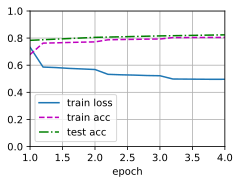

In [17]:
#@ TRAINING AND EVALUATING THE MODEL: 
lr, num_epochs = 0.001, 4                                             # Initializing Parameters. 
trainer = torch.optim.Adam(net.parameters(), lr=lr)                   # Initializing Adam Optimizer. 
loss = nn.CrossEntropyLoss(reduction="none")                          # Initializing Cross Entropy Loss Function. 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, 
               devices)                                               # Training the Model. 

### **EVALUATING THE MODEL:**

- I will define the prediction function to output the logical relationship between a pair of premise and hypothesis. 

In [18]:
#@ DEFINING THE PREDICTION FUNCTION: 
def predict_snli(net, vocab, premise, hypothesis):                  # Prediction Function. 
  net.eval()                                                        # Initializing Evaluation Mode. 
  premise = torch.tensor(vocab[premise], device=d2l.try_gpu())      # Changing into Tensors. 
  hypothesis = torch.tensor(vocab[hypothesis],device=d2l.try_gpu()) # Changing into Tensors. 
  label = torch.argmax(net([premise.reshape((1, -1)), 
                            hypothesis.reshape((1, -1))]), dim=1)   # Implementation of Model. 
  return "entailment" if label == 0 else "contradiction" \
          if label == 1 else "neutral"

In [22]:
#@ IMPLEMENTATION: 
predict_snli(net, vocab, ["It", "is", "raining", "."], 
             ["It", "is", "cold", "."])                             # Prediction. 

'entailment'